#### Адонин Антон 22931

# Simpsons Classification
#### В данной лабораторной работе представлено обучение нейронной сети ResNet50 для распознавания героев мультсериала "Симпсоны".
##### Сама работа состоит из 2 этапов:
##### 1. Работа с данными.
    a. Удаление дубликатов.
    b. Обогащение тренировочных данных. Аугментация классов с малой репрезентативностью.

##### 2. Работа с моделью.
    a. Подсчет среднего и стандартного отклонения тренировочной выборки. (Для нормализации).
    b. Разбиение тренировочных данных на выборки: тренировочная, валидационная.
    c. Создание лоадеров и инициализация модели.
    d. Обучение модели.
    e. Тестирование модели. Подсчет метрик.

#### Импортируем необходимые модули

In [4]:
import hashlib
import math
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
# import pandas as pd
# import seaborn as sns

# 1. Работа с данными.

Прописываем относительный путь до директорий с данными

In [5]:
train_dir = Path('./train_dir/simpsons_dataset/')
test_dir = Path('./test_dir/kaggle_simpson_testset/')


def list_of_files(directory: str, with_aug=True):
    """
    Returns a list of files in a directory.
    :param directory: 
    :param with_aug: True by default. Returns augmented files which exist in directory if True.
    :return: list of file paths
    """
    filename = '*/*.jpg'
    if with_aug:
        filename = '*/*.*'
    files_training = glob(os.path.join(directory, filename))
    print('Number of images in Training dir:', len(files_training))
    return files_training


list_of_files(train_dir)

Number of images in Training dir: 31015


['train_dir/simpsons_dataset/maggie_simpson/random_aug_pic346.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic420.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic434.png',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0028.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic352.png',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0000.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/pic_0014.jpg',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic408.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic385.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic391.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic144.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic150.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic178.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic187.png',
 'train_dir/simpsons_dataset/maggie_simpson/random_aug_pic193.png',
 'train

In [6]:
# Имена классов
CLASS_NAMES = []
for i in os.listdir(train_dir):
    if not i.startswith('.'):
        CLASS_NAMES.append(i)

In [7]:
def generate_md5_hash(file_path):
    """
    Returns md5 hash of file by its path.
    :param file_path: Path of file.
    :return: str, md5 hash of file
    """
    with open(file_path, 'rb') as file:
        # Read the file contents
        data = file.read()

        # Calculate the MD5 hash
        md5_hash = hashlib.md5(data).hexdigest()

        return md5_hash

In [8]:
def remove_duplicates_from_dir(directory) -> None:
    """
    Removes duplicates from directory.
    :param directory: 
    :return: None
    """
    hashes = {}
    file_paths = glob(os.path.join(directory, '*.jpg'))
    for path in file_paths:
        hash_image = generate_md5_hash(path)
        if hash_image not in hashes:
            hashes[hash_image] = []
        hashes[hash_image].append(path)
    duplicate_counter = 0
    for hash, images in hashes.items():
        if len(images) > 1:
            for image in images[1:]:
                os.remove(image)
                duplicate_counter += 1
    if duplicate_counter > 0:
        print(f"removed {duplicate_counter} duplicate from {dir}")

Удаляем дубликаты

In [9]:
# Удаление дубликатов из папок
for dir in glob(os.path.join(train_dir, "*")):
    remove_duplicates_from_dir(dir)
for dir in glob(os.path.join(test_dir, "*")):
    remove_duplicates_from_dir(dir)

In [10]:
def items_per_class(directory):
    """
    Returns the number of items in class.
    :param directory: parent directory of classes 
    :return: dict, {class : number_of_items}
    """
    class_quantity = {i: 0 for i in CLASS_NAMES}
    for class_name in CLASS_NAMES:
        if not class_name.startswith('.'):
            class_path = os.path.join(directory, class_name)
            num_images = len(glob(os.path.join(class_path, '*.*')))
            class_quantity[class_name] += num_images
    return class_quantity

Total classes: 42
Items per class:
maggie_simpson 503
charles_montgomery_burns 1193
patty_bouvier 504
ralph_wiggum 504
chief_wiggum 986
milhouse_van_houten 1079
rainier_wolfcastle 506
cletus_spuckler 506
martin_prince 505
lenny_leonard 501
sideshow_bob 877
fat_tony 504
selma_bouvier 503
barney_gumble 502
lionel_hutz 192
gil 504
moe_szyslak 1452
carl_carlson 503
edna_krabappel 501
snake_jailbird 505
groundskeeper_willie 501
sideshow_mel 508
ned_flanders 1454
abraham_grampa_simpson 913
krusty_the_clown 1206
waylon_smithers 502
apu_nahasapeemapetilon 623
marge_simpson 1291
comic_book_guy 501
nelson_muntz 501
mayor_quimby 501
kent_brockman 501
professor_john_frink 505
principal_skinner 1194
bart_simpson 1342
lisa_simpson 1354
otto_mann 512
troy_mcclure 512
miss_hoover 502
disco_stu 512
homer_simpson 2246
agnes_skinner 504


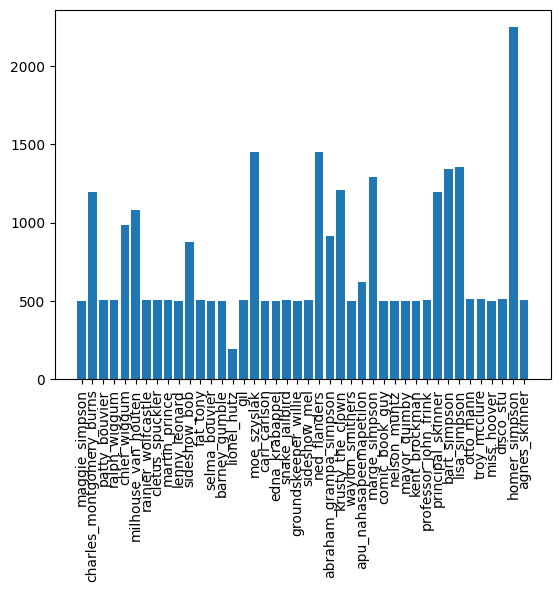

In [11]:
def print_classes_plot(directory):
    """
    Shows plot of the number of items in classes.
    :param directory: parent directory of classes.
    :return: None
    """
    class_stat = items_per_class(directory)
    plt.bar(class_stat.keys(), class_stat.values(), align='center')
    plt.xticks(rotation=90)
    print(f"Total classes: {len(class_stat.keys())}")
    print(f"Items per class:")
    for key, value in class_stat.items():
        print(key, value)
    plt.show()


print_classes_plot(train_dir)

In [12]:
def get_low_quality_classes(left, right):
    """
    Returns a list of classes which are left <= N <= right. Where N = number of items. 
    :param left: int
    :param right: int
    :return: list of classes
    """
    low_quantity_classes = []
    class_stat = items_per_class(train_dir)
    for key, value in class_stat.items():
        if left <= value <= right:
            low_quantity_classes.append(key)
            print(key, value)

    print(f"Classes with items [{left}:{right}] : {len(low_quantity_classes)}")
    print(low_quantity_classes)
    return low_quantity_classes

In [13]:
def remove_augmentations():
    """
    Removes "basic" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/aug*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

def remove_random_augmentations():
    """
    Removes "random" augmentations from train dir
    :return: None
    """
    files_augmented = glob(os.path.join(train_dir, '*/random*.png'))
    for file in files_augmented:
        os.remove(file)
    print("All augmentations removed: ", len(files_augmented))

# remove_augmentations()
# remove_random_augmentations()

In [14]:


def apply_basic_aug():
    """
    Применение "базовой" аугментации к классу.
    (1) размытие по гауссу с ядром (25, 25)
    (2) Горизонтальный флип.
    
    Функция делает из 3 фото 12 штук. Нужна чтобы раздуть классы с очень маленькой численностью.
    (1) 3 базовых => 3 базовых + 3 размытых
    (2) 3 базовых 3 размытых => 3 базовых 3 размытых + 3 флипнутые базовые 3 флипнутые размытые 
    """
    blur_transform = transforms.GaussianBlur(kernel_size=(25, 25), sigma=(0.2, 4.0))
    flip_transform = transforms.RandomHorizontalFlip(p=1)

    classes = get_low_quality_classes(0, 30)

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            blurred = blur_transform(image)
            blurred.save(path)
            pic_number += 1
    print(f"blurred")

    for class_name in tqdm(classes):
        dir_path = os.path.join(train_dir, class_name)
        pictures = glob(os.path.join(dir_path, '*'))
        pic_number = len(pictures)
        for filename in pictures:
            image = Image.open(filename)
            path = os.path.join(dir_path, f"aug_pic{pic_number}.png")
            flipped = flip_transform(image)
            flipped.save(path)
            pic_number += 1
    print(f"flipped")


apply_basic_aug()

Classes with items [0:30] : 0
[]


0it [00:00, ?it/s]


blurred


0it [00:00, ?it/s]

flipped


In [15]:
# Доделываем последний класс
classes = get_low_quality_classes(0, 500)
if len(classes) == 1:
    classes = []
for class_name in classes:
    dir_path = os.path.join(train_dir, class_name)
    pictures = glob(os.path.join(dir_path, '*'))
    pic_number = len(pictures)
    aug_per_pic = math.ceil((500 - pic_number) / pic_number)
    random_augment_transform = transforms.Compose([transforms.PILToTensor(),
                                                   transforms.RandAugment(num_ops=aug_per_pic + 2),
                                                   transforms.ToPILImage()])
    # Максимально возможное количество аугментаций для каждого класса - 15 на каждую картинку
    if aug_per_pic > 15:
        aug_per_pic = 15
    rand = transforms.RandAugment(num_ops=aug_per_pic + 2)
    for filename in tqdm(pictures):
        image = Image.open(filename)
        for i in range(aug_per_pic):
            path = os.path.join(dir_path, f"random_aug_pic{pic_number}.png")
            augmented = rand(image)
            augmented.save(path)
            pic_number += 1
        if pic_number > 500:
            break

lionel_hutz 192
Classes with items [0:500] : 1
['lionel_hutz']


Total classes: 42
Items per class:
maggie_simpson 503
charles_montgomery_burns 1193
patty_bouvier 504
ralph_wiggum 504
chief_wiggum 986
milhouse_van_houten 1079
rainier_wolfcastle 506
cletus_spuckler 506
martin_prince 505
lenny_leonard 501
sideshow_bob 877
fat_tony 504
selma_bouvier 503
barney_gumble 502
lionel_hutz 192
gil 504
moe_szyslak 1452
carl_carlson 503
edna_krabappel 501
snake_jailbird 505
groundskeeper_willie 501
sideshow_mel 508
ned_flanders 1454
abraham_grampa_simpson 913
krusty_the_clown 1206
waylon_smithers 502
apu_nahasapeemapetilon 623
marge_simpson 1291
comic_book_guy 501
nelson_muntz 501
mayor_quimby 501
kent_brockman 501
professor_john_frink 505
principal_skinner 1194
bart_simpson 1342
lisa_simpson 1354
otto_mann 512
troy_mcclure 512
miss_hoover 502
disco_stu 512
homer_simpson 2246
agnes_skinner 504


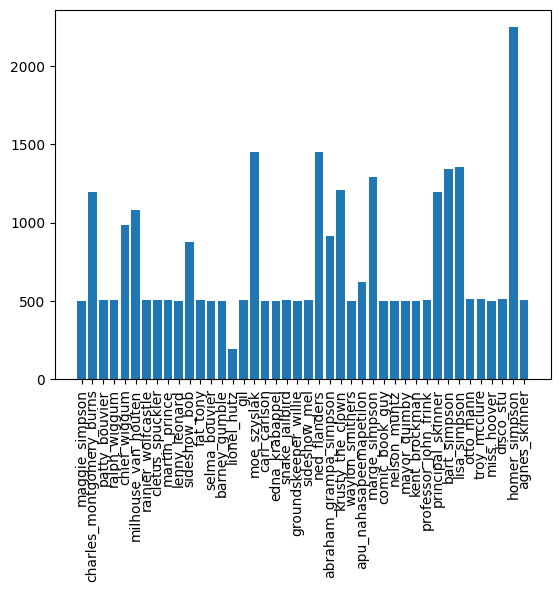

In [16]:
print_classes_plot(train_dir)

# 2. Работа с моделью.

In [19]:
images_dataset = datasets.ImageFolder(root=train_dir)
images_dataset.idx_to_class = {v: k for k, v in images_dataset.class_to_idx.items()}

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
)

In [35]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split

def get_loaders(dataset, train_size=0.9, batch_size=16):
    """
    Splits train dataset to train and validation samples.
    Returns loaders.
    :param dataset: 
    :param batch_size: 
    :return: (train_loader, validation_loader) - tuple
    """
    length = len(dataset)
    indicies = list(range(length))
    train_ind, val_ind = train_test_split(indicies, train_size=train_size, stratify=dataset.targets, shuffle=True, random_state=42)
    train_sampler = SubsetRandomSampler(train_ind)
    valid_sampler = SubsetRandomSampler(val_ind)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    return train_loader, validation_loader


#### Подсчет среднего и стандартного отклонения тренировочной выборки.

In [17]:
def calculate_mean_std(filenames):
    """
    Calculate the mean and std of the images
    :param filenames: list of images
    :return: (mean, std) - tuple
    """
    num_channels = 3
    dataset_mean = torch.zeros(num_channels)
    dataset_std = torch.zeros(num_channels)
    num_images = len(filenames)
    print('==> Computing mean and std..')
    for filename in tqdm(filenames):
        ToTensor = transforms.ToTensor()
        image_tensor = ToTensor(Image.open(filename))
        for i in range(num_channels):
            dataset_mean[i] += image_tensor[i, :, :].mean()
            dataset_std[i] += image_tensor[i, :, :].std()
    dataset_mean.div_(num_images)
    dataset_std.div_(num_images)
    print(f"Mean: {dataset_mean}")
    print(f"std: {dataset_std}")
    return dataset_mean, dataset_std

In [ ]:
from sklearn.preprocessing import StandardScaler


In [18]:
# files_training = list_of_files(train_dir, with_aug=False)
# result = calculate_mean_std(files_training)
# print(result)
total_mean, total_std = torch.tensor([0.4298, 0.3888, 0.3424]), torch.tensor([0.2325, 0.2168, 0.2363])
no_aug_mean, no_aug_std = torch.tensor([0.4622, 0.4075, 0.3524]), torch.tensor([0.2167, 0.1961, 0.2246])


In [ ]:

dataset_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224), transforms.ToTensor(),
                                        transforms.Normalize(mean=total_mean, std=total_std)])


In [36]:
num_epochs = 300
learning_rate = 0.001
batch_size = 8
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
min_valid_loss = np.inf
print(device)

mps


In [37]:
model = torchvision.models.resnet50(pretrained=False)
model_filename = "saved_model.pth"
if model_filename in os.listdir():
    model.load_state_dict(torch.load(model_filename,map_location=torch.device(device)))

# Set the model to run on the device
model = model.to(device)

train_loader, validation_loader = get_loaders(images_dataset, batch_size=batch_size)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [38]:
def train():
    # Train the model...
    for epoch in range(num_epochs):
        print(f"Running {epoch + 1} epoch")
        train_loss = 0.0
        model.train()
        for inputs, labels in tqdm(train_loader):
            # Move input and label tensors to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out the optimizer
            optimizer.zero_grad()
    
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            train_loss = loss.item() * inputs.size(0)
    
            # Backward pass
            loss.backward()
            optimizer.step()
        valid_loss = 0.0
        
        model.eval()  # Optional when not using Model Specific layer
        for inputs, labels in tqdm(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            target = model(inputs)
            loss = criterion(target, labels)
            valid_loss = loss.item() * inputs.size(0)
        # Print the loss for every epoch
        print(
            f'Epoch {epoch + 1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(validation_loader)}')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
    
    print(f'Finished Training, Loss: {loss.item():.4f}')

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

Total classes: 42
Items per class:
maggie_simpson 0
charles_montgomery_burns 47
patty_bouvier 0
ralph_wiggum 0
chief_wiggum 49
milhouse_van_houten 47
rainier_wolfcastle 0
cletus_spuckler 0
martin_prince 0
lenny_leonard 42
sideshow_bob 47
fat_tony 0
selma_bouvier 0
barney_gumble 0
lionel_hutz 0
gil 0
moe_szyslak 49
carl_carlson 0
edna_krabappel 46
snake_jailbird 0
groundskeeper_willie 0
sideshow_mel 0
ned_flanders 49
abraham_grampa_simpson 46
krusty_the_clown 48
waylon_smithers 0
apu_nahasapeemapetilon 50
marge_simpson 50
comic_book_guy 49
nelson_muntz 48
mayor_quimby 47
kent_brockman 47
professor_john_frink 0
principal_skinner 50
bart_simpson 47
lisa_simpson 50
otto_mann 0
troy_mcclure 0
miss_hoover 0
disco_stu 0
homer_simpson 47
agnes_skinner 0


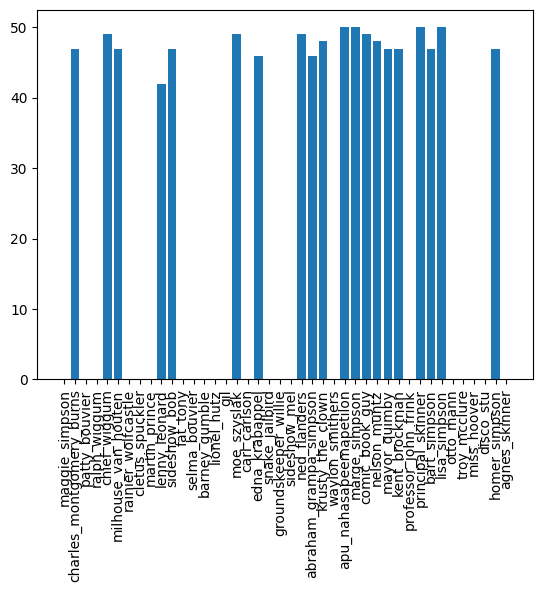

In [40]:
print_classes_plot(test_dir)

In [41]:
test_dataset = datasets.ImageFolder(
    root=test_dir, transform=dataset_transform
)
test_dataset.idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}


In [42]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True)

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lionel_hutz',
 20: 'lisa_simpson',
 21: 'maggie_simpson',
 22: 'marge_simpson',
 23: 'martin_prince',
 24: 'mayor_quimby',
 25: 'milhouse_van_houten',
 26: 'miss_hoover',
 27: 'moe_szyslak',
 28: 'ned_flanders',
 29: 'nelson_muntz',
 30: 'otto_mann',
 31: 'patty_bouvier',
 32: 'principal_skinner',
 33: 'professor_john_frink',
 34: 'rainier_wolfcastle',
 35: 'ralph_wiggum',
 36: 'selma_bouvier',
 37: 'sideshow_bob',
 38: 'sideshow_mel',
 39: 'snake_jailbird',
 40: 'troy_mcclure',
 41: 'waylon_smithers'}

In [43]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        class_names = [test_dataset.idx_to_class[int(idx)] for idx in labels]
        # y_true.extend([images_dataset.class_to_idx[name] for name in class_names])
        y_true.extend(class_names)
        
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        
        outputs = outputs
        _, predicted = torch.max(outputs, 1)
        # y_pred.extend(predicted.cpu().numpy())
        y_pred.extend([images_dataset.idx_to_class[idx] for idx in predicted.cpu().numpy()])


100%|██████████| 120/120 [00:09<00:00, 13.08it/s]


In [44]:
count = 0
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        count += 1
print(count)
print(len(y_true))
print(count / len(y_true) * 100)

893
955
93.50785340314135


In [45]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred, labels=test_dataset.classes)

/var/folders/gq/fm7sk90s2l327ztx9drv3yjh0000gn/T/ipykernel_45003/3451426370.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dataset.classes)
/var/folders/gq/fm7sk90s2l327ztx9drv3yjh0000gn/T/ipykernel_45003/3451426370.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(test_dataset.classes)


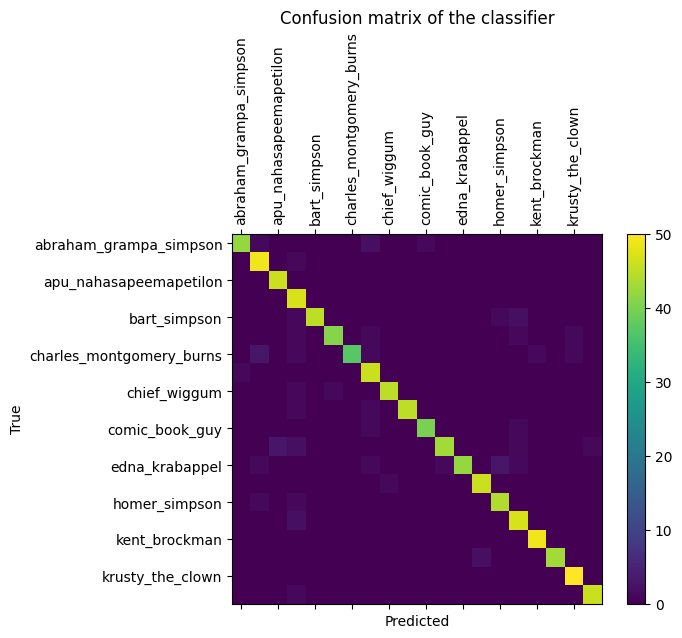

In [48]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels(test_dataset.classes)
ax.set_yticklabels(test_dataset.classes)
ax.yaxis.set_major_locator(MaxNLocator(prune='both'))
ax.xaxis.set_major_locator(MaxNLocator(prune='both'))
plt.xticks(rotation=90)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()